In [1]:
import pandas as pd
import pmdarima as pm

import os.path
from os import path
import numpy as np
import pickle
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgb

In [2]:
def smape_error(forecast, actual):
    numerator = np.absolute(forecast-actual)
    denominator = np.absolute(forecast) + np.absolute(actual)

    num_samples = len(numerator)

    return 100/num_samples * np.sum(numerator/denominator)

In [3]:
df = pd.read_pickle('1.collect_data/data_files/1hr.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

blockface_detail = pd.read_csv('1.collect_data/blockface_detail.csv')

In [4]:
# load weather
weather = pd.read_pickle('1.collect_data/data_files/weather/2010-2019_daily_weather.pkl')
weather = weather[weather.index > '2019-01-01'].resample('H').ffill()
weather.head()

,PRCP,SNOW,TAVG,TMAX,TMIN
DATE,,,,,
2019-01-02 00:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 01:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 02:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 03:00:00,0.01,0.0,40.0,47.0,33.0
2019-01-02 04:00:00,0.01,0.0,40.0,47.0,33.0


In [5]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose':-1, 
}

In [6]:
df.head()

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
0,1001,2012-01-03 09:00:00,0.983333,7.0,0.140476
1,1001,2012-01-03 10:00:00,2.016667,7.0,0.288095
2,1001,2012-01-03 11:00:00,4.633333,7.0,0.661905
3,1001,2012-01-03 12:00:00,3.283333,7.0,0.469048
4,1001,2012-01-03 13:00:00,1.116667,7.0,0.159524


In [7]:
start_date = '2019-01-01'

df_2019 = df[df['OccupancyDateTime'] > (start_date)]
df_2019

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
21190,1001,2019-01-02 09:00:00,0.000000,6.0,0.000000
21191,1001,2019-01-02 10:00:00,0.000000,6.0,0.000000
21192,1001,2019-01-02 11:00:00,0.666667,6.0,0.111111
21193,1001,2019-01-02 12:00:00,2.133333,6.0,0.355556
21194,1001,2019-01-02 13:00:00,1.783333,6.0,0.297222
...,...,...,...,...,...
38586661,121340,2019-08-30 13:00:00,1.100000,2.0,0.550000
38586662,121340,2019-08-30 14:00:00,0.916667,2.0,0.458333
38586663,121340,2019-08-30 15:00:00,0.633333,2.0,0.316667
38586664,121340,2019-08-30 16:00:00,0.000000,2.0,0.000000


In [8]:
block_dfs = []


#block = 1001

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results2/arima.%d.pkl' % block
    if path.exists(block_file):

        # select only data for block, timeframe
        mask = (df_2019['SourceElementKey'] == block) 
        curr = df_2019[mask].set_index('OccupancyDateTime')

        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()


        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]

        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)


        #break

        in_sample_preds = mdl.predict_in_sample()
        test_preds = mdl.predict(n_periods=test.shape[0])

        all_preds = np.concatenate((in_sample_preds, test_preds), axis=0)
        all_resids = curr.PercentOccupied - all_preds
        curr['Residuals_pct_occupied_sarima'] =  all_resids
        curr['SARIMA_Preds'] = all_preds

        
        block_dfs.append(pd.merge(curr, weather, left_index=True, right_index=True))





In [9]:
last_year = pd.concat(block_dfs)
last_year.index.name='OccupancyDateTime'

In [10]:
merged = pd.merge(last_year.reset_index(), 
                  blockface_detail, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop(['sourceelementkey', 
                                                     'location', 
                                                     'parkingcategory', 
                                                     'Unnamed: 0', 
                                                     'parkingtimelimitcategory'], axis=1)

In [11]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,TMAX,TMIN,blockfacename,paidparkingarea,paidparkingsubarea,parkingspacecount,sideofstreet,latitude,longitude
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,47.0,33.0,1ST AVE BETWEEN CHERRY ST AND COLUMBIA ST,Pioneer Square,Core,4,SW,47.602873,-122.334694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,80.0,61.0,7TH AVE S BETWEEN S WELLER ST AND S LANE ST,Chinatown/ID,Core,8,E,47.597087,-122.323637


In [12]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day
merged['IsWeekend'] = (merged.OccupancyDateTime.dt.dayofweek >= 5)

In [13]:
merged

,OccupancyDateTime,SourceElementKey,PaidOccupancy,ParkingSpaceCount,PercentOccupied,Residuals_pct_occupied_sarima,SARIMA_Preds,PRCP,SNOW,TAVG,...,parkingspacecount,sideofstreet,latitude,longitude,Month,Year,Hour,DayOfWeek,Day,IsWeekend
0,2019-01-02 09:00:00,1001,0.000000,6.0,0.000000,-0.283089,0.283089,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,9,2,2,False
1,2019-01-02 10:00:00,1001,0.000000,6.0,0.000000,-0.118188,0.118188,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,10,2,2,False
2,2019-01-02 11:00:00,1001,0.666667,6.0,0.111111,-0.026895,0.138006,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,11,2,2,False
3,2019-01-02 12:00:00,1001,2.133333,6.0,0.355556,0.147407,0.208148,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,12,2,2,False
4,2019-01-02 13:00:00,1001,1.783333,6.0,0.297222,-0.065029,0.362252,0.01,0.0,40.0,...,4,SW,47.602873,-122.334694,1,2019,13,2,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234488,2019-08-31 15:00:00,8306,3.100000,8.0,0.387500,0.059450,0.328050,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,15,5,31,True
234489,2019-08-31 16:00:00,8306,4.100000,8.0,0.512500,0.221556,0.290944,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,16,5,31,True
234490,2019-08-31 17:00:00,8306,5.633333,8.0,0.704167,0.363937,0.340230,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,17,5,31,True
234491,2019-08-31 18:00:00,8306,6.983333,8.0,0.872917,0.425735,0.447181,0.00,0.0,70.5,...,8,E,47.597087,-122.323637,8,2019,18,5,31,True


In [14]:
merged.paidparkingarea.unique()

array(['Pioneer Square', 'Commercial Core', 'Belltown', 'Uptown',
       'Pike-Pine', 'University District', '12th Avenue', 'Capitol Hill',
       'Roosevelt', 'Ballard', 'Columbia City', 'Chinatown/ID',
       'Denny Triangle', 'First Hill'], dtype=object)

In [15]:
for col in ['SourceElementKey', 'DayOfWeek', 'Hour', 'paidparkingarea']:
    merged[col] = merged[col].astype('category')

In [16]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234493 entries, 0 to 234492
Data columns (total 25 columns):
OccupancyDateTime                234493 non-null datetime64[ns]
SourceElementKey                 234493 non-null category
PaidOccupancy                    234493 non-null float64
ParkingSpaceCount                234493 non-null float64
PercentOccupied                  234493 non-null float64
Residuals_pct_occupied_sarima    234493 non-null float64
SARIMA_Preds                     234493 non-null float64
PRCP                             234493 non-null float64
SNOW                             234493 non-null float64
TAVG                             234493 non-null float64
TMAX                             234493 non-null float64
TMIN                             234493 non-null float64
blockfacename                    234493 non-null object
paidparkingarea                  234493 non-null category
paidparkingsubarea               205525 non-null object
parkingspacecount          

In [17]:
test_date = '2019-06-20'

mask = merged['OccupancyDateTime'] > (test_date)
df_train = merged[~mask]
df_test = merged[mask]

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165013 entries, 0 to 233748
Data columns (total 25 columns):
OccupancyDateTime                165013 non-null datetime64[ns]
SourceElementKey                 165013 non-null category
PaidOccupancy                    165013 non-null float64
ParkingSpaceCount                165013 non-null float64
PercentOccupied                  165013 non-null float64
Residuals_pct_occupied_sarima    165013 non-null float64
SARIMA_Preds                     165013 non-null float64
PRCP                             165013 non-null float64
SNOW                             165013 non-null float64
TAVG                             165013 non-null float64
TMAX                             165013 non-null float64
TMIN                             165013 non-null float64
blockfacename                    165013 non-null object
paidparkingarea                  165013 non-null category
paidparkingsubarea               144849 non-null object
parkingspacecount          

In [19]:
rf_columns = ['SourceElementKey', 'Month', 'DayOfWeek', 
              'latitude', 'longitude', 'IsWeekend', 
              'paidparkingarea', 'Hour', 'Day',
              'PRCP',  'SNOW',  'TAVG',  
             ]

In [20]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['Residuals_pct_occupied_sarima'],
                            feature_name=rf_columns)
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['Residuals_pct_occupied_sarima'], 
                          feature_name=rf_columns,
                          reference=rf_train)

In [21]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6,
    'n_iter':1000,
    
}

In [22]:
print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('sarima_rf_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l2: 0.0510298	valid_0's l1: 0.165322
[2]	valid_0's l2: 0.0508591	valid_0's l1: 0.164833
[3]	valid_0's l2: 0.0508976	valid_0's l1: 0.16494
[4]	valid_0's l2: 0.0509441	valid_0's l1: 0.165106
[5]	valid_0's l2: 0.050948	valid_0's l1: 0.165147
[6]	valid_0's l2: 0.0509095	valid_0's l1: 0.165137
[7]	valid_0's l2: 0.0508942	valid_0's l1: 0.165132
[8]	valid_0's l2: 0.0508725	valid_0's l1: 0.16515
[9]	valid_0's l2: 0.050926	valid_0's l1: 0.165253
[10]	valid_0's l2: 0.0509039	valid_0's l1: 0.165201
[11]	valid_0's l2: 0.0509494	valid_0's l1: 0.165286
[12]	valid_0's l2: 0.0509502	valid_0's l1: 0.165228
[13]	valid_0's l2: 0.0509516	valid_0's l1: 0.165229
[14]	valid_0's l2: 0.0509533	valid_0's l1: 0.165203
[15]	valid_0's l2: 0.0509624	valid_0's l1: 0.165211
[16]	valid_0's l2: 0.0509612	valid_0's l1: 0.165214
[17]	valid_0's l2: 0.0509572	valid_0's l1: 0.165214
[18]	valid_0's l2: 0.0509556	valid_0's l1: 0.165219
[19]	valid_0's l2: 0.0509488	valid_0's l1: 0.165195
[20]	valid_0's l2: 0.0509

[167]	valid_0's l2: 0.0508739	valid_0's l1: 0.165077
[168]	valid_0's l2: 0.0508731	valid_0's l1: 0.165077
[169]	valid_0's l2: 0.0508721	valid_0's l1: 0.165076
[170]	valid_0's l2: 0.0508706	valid_0's l1: 0.165073
[171]	valid_0's l2: 0.0508699	valid_0's l1: 0.165071
[172]	valid_0's l2: 0.0508693	valid_0's l1: 0.16507
[173]	valid_0's l2: 0.0508689	valid_0's l1: 0.165069
[174]	valid_0's l2: 0.0508685	valid_0's l1: 0.165069
[175]	valid_0's l2: 0.0508682	valid_0's l1: 0.16507
[176]	valid_0's l2: 0.0508675	valid_0's l1: 0.16507
[177]	valid_0's l2: 0.0508666	valid_0's l1: 0.165068
[178]	valid_0's l2: 0.0508684	valid_0's l1: 0.165072
[179]	valid_0's l2: 0.0508675	valid_0's l1: 0.165071
[180]	valid_0's l2: 0.0508667	valid_0's l1: 0.165069
[181]	valid_0's l2: 0.0508692	valid_0's l1: 0.165074
[182]	valid_0's l2: 0.0508689	valid_0's l1: 0.165073
[183]	valid_0's l2: 0.0508708	valid_0's l1: 0.165077
[184]	valid_0's l2: 0.05087	valid_0's l1: 0.165075
[185]	valid_0's l2: 0.0508697	valid_0's l1: 0.16507

[338]	valid_0's l2: 0.0508683	valid_0's l1: 0.165074
[339]	valid_0's l2: 0.0508685	valid_0's l1: 0.165074
[340]	valid_0's l2: 0.0508678	valid_0's l1: 0.165072
[341]	valid_0's l2: 0.0508673	valid_0's l1: 0.165071
[342]	valid_0's l2: 0.0508679	valid_0's l1: 0.165073
[343]	valid_0's l2: 0.0508678	valid_0's l1: 0.165073
[344]	valid_0's l2: 0.0508673	valid_0's l1: 0.165072
[345]	valid_0's l2: 0.0508668	valid_0's l1: 0.16507
[346]	valid_0's l2: 0.0508678	valid_0's l1: 0.165072
[347]	valid_0's l2: 0.0508673	valid_0's l1: 0.165072
[348]	valid_0's l2: 0.050867	valid_0's l1: 0.165072
[349]	valid_0's l2: 0.0508665	valid_0's l1: 0.165071
[350]	valid_0's l2: 0.050866	valid_0's l1: 0.165071
[351]	valid_0's l2: 0.0508655	valid_0's l1: 0.165069
[352]	valid_0's l2: 0.0508654	valid_0's l1: 0.165069
[353]	valid_0's l2: 0.0508657	valid_0's l1: 0.165069
[354]	valid_0's l2: 0.0508672	valid_0's l1: 0.165072
[355]	valid_0's l2: 0.0508673	valid_0's l1: 0.165073
[356]	valid_0's l2: 0.0508674	valid_0's l1: 0.165

[507]	valid_0's l2: 0.0508706	valid_0's l1: 0.165086
[508]	valid_0's l2: 0.0508706	valid_0's l1: 0.165086
[509]	valid_0's l2: 0.0508705	valid_0's l1: 0.165086
[510]	valid_0's l2: 0.0508704	valid_0's l1: 0.165085
[511]	valid_0's l2: 0.0508705	valid_0's l1: 0.165086
[512]	valid_0's l2: 0.0508698	valid_0's l1: 0.165084
[513]	valid_0's l2: 0.0508699	valid_0's l1: 0.165085
[514]	valid_0's l2: 0.0508696	valid_0's l1: 0.165084
[515]	valid_0's l2: 0.0508703	valid_0's l1: 0.165086
[516]	valid_0's l2: 0.0508703	valid_0's l1: 0.165086
[517]	valid_0's l2: 0.0508703	valid_0's l1: 0.165086
[518]	valid_0's l2: 0.0508701	valid_0's l1: 0.165085
[519]	valid_0's l2: 0.0508701	valid_0's l1: 0.165086
[520]	valid_0's l2: 0.0508702	valid_0's l1: 0.165086
[521]	valid_0's l2: 0.0508702	valid_0's l1: 0.165086
[522]	valid_0's l2: 0.0508702	valid_0's l1: 0.165085
[523]	valid_0's l2: 0.0508702	valid_0's l1: 0.165085
[524]	valid_0's l2: 0.0508703	valid_0's l1: 0.165085
[525]	valid_0's l2: 0.0508712	valid_0's l1: 0.

[675]	valid_0's l2: 0.0508659	valid_0's l1: 0.165082
[676]	valid_0's l2: 0.0508658	valid_0's l1: 0.165082
[677]	valid_0's l2: 0.0508656	valid_0's l1: 0.16508
[678]	valid_0's l2: 0.0508654	valid_0's l1: 0.16508
[679]	valid_0's l2: 0.0508652	valid_0's l1: 0.165079
[680]	valid_0's l2: 0.050865	valid_0's l1: 0.165079
[681]	valid_0's l2: 0.0508649	valid_0's l1: 0.165079
[682]	valid_0's l2: 0.0508646	valid_0's l1: 0.165079
[683]	valid_0's l2: 0.0508654	valid_0's l1: 0.16508
[684]	valid_0's l2: 0.0508661	valid_0's l1: 0.165082
[685]	valid_0's l2: 0.050866	valid_0's l1: 0.165081
[686]	valid_0's l2: 0.0508657	valid_0's l1: 0.165081
[687]	valid_0's l2: 0.0508657	valid_0's l1: 0.165081
[688]	valid_0's l2: 0.0508663	valid_0's l1: 0.165082
[689]	valid_0's l2: 0.0508663	valid_0's l1: 0.165082
[690]	valid_0's l2: 0.0508663	valid_0's l1: 0.165082
[691]	valid_0's l2: 0.050866	valid_0's l1: 0.165081
[692]	valid_0's l2: 0.0508658	valid_0's l1: 0.165081
[693]	valid_0's l2: 0.0508656	valid_0's l1: 0.16508


[836]	valid_0's l2: 0.0508639	valid_0's l1: 0.165079
[837]	valid_0's l2: 0.0508639	valid_0's l1: 0.165079
[838]	valid_0's l2: 0.0508644	valid_0's l1: 0.16508
[839]	valid_0's l2: 0.0508649	valid_0's l1: 0.165081
[840]	valid_0's l2: 0.0508649	valid_0's l1: 0.165081
[841]	valid_0's l2: 0.0508648	valid_0's l1: 0.16508
[842]	valid_0's l2: 0.0508654	valid_0's l1: 0.165082
[843]	valid_0's l2: 0.0508653	valid_0's l1: 0.165082
[844]	valid_0's l2: 0.0508652	valid_0's l1: 0.165081
[845]	valid_0's l2: 0.0508657	valid_0's l1: 0.165083
[846]	valid_0's l2: 0.0508658	valid_0's l1: 0.165083
[847]	valid_0's l2: 0.0508658	valid_0's l1: 0.165083
[848]	valid_0's l2: 0.0508657	valid_0's l1: 0.165082
[849]	valid_0's l2: 0.0508657	valid_0's l1: 0.165082
[850]	valid_0's l2: 0.0508658	valid_0's l1: 0.165082
[851]	valid_0's l2: 0.0508656	valid_0's l1: 0.165082
[852]	valid_0's l2: 0.0508655	valid_0's l1: 0.165081
[853]	valid_0's l2: 0.0508653	valid_0's l1: 0.16508
[854]	valid_0's l2: 0.0508651	valid_0's l1: 0.165

[1000]	valid_0's l2: 0.050864	valid_0's l1: 0.165078
Saving model...


In [23]:
y_pred = gbm_rf.predict(merged[rf_columns], num_iteration=gbm_rf.best_iteration)

In [24]:
merged['RF_results'] = y_pred
merged['SARIMA_Plus_RF'] = merged['RF_results'] + merged['SARIMA_Preds']

In [25]:
block = 1001

mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
curr = merged[mask]


In [26]:
curr[['OccupancyDateTime', 'RF_results', 'SARIMA_Preds', 'SARIMA_Plus_RF', 'PercentOccupied']]

,OccupancyDateTime,RF_results,SARIMA_Preds,SARIMA_Plus_RF,PercentOccupied
1419,2019-06-20 08:00:00,-0.014569,0.122758,0.108189,0.097043
1420,2019-06-20 09:00:00,0.022125,0.138143,0.160268,0.050000
1421,2019-06-20 10:00:00,0.029592,0.386654,0.416246,0.216667
1422,2019-06-20 11:00:00,0.025198,0.350114,0.375312,0.529167
1423,2019-06-20 12:00:00,0.018287,0.609321,0.627608,0.620833
...,...,...,...,...,...
2034,2019-08-31 13:00:00,-0.037818,0.452743,0.414924,0.250000
2035,2019-08-31 14:00:00,0.012248,0.280756,0.293004,0.283333
2036,2019-08-31 15:00:00,0.012248,0.296082,0.308330,0.141667
2037,2019-08-31 16:00:00,0.002765,0.245220,0.247985,0.420833


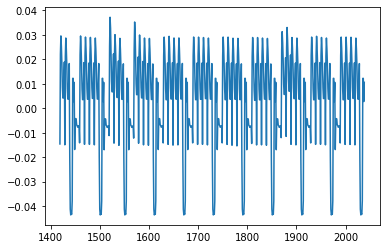

In [27]:
plt.figure()
plt.plot(curr.RF_results)
#plt.plot(curr.Residuals_pct_occupied_sarima)
plt.show()

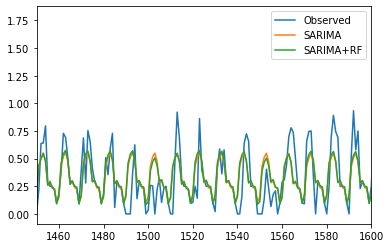

In [28]:
fig, ax = plt.subplots()
ax.plot(curr['PercentOccupied'], label='Observed')

ax.plot(curr['SARIMA_Preds'], label='SARIMA')
ax.plot(curr['SARIMA_Plus_RF'], label='SARIMA+RF')
ax.legend()
ax.set_xlim(1450,1600)
plt.show()

In [29]:
arima2_results = pd.read_pickle('arima_results2/arima_results.pkl')
arima2_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,SurroundsTest,NonSeasonal,Seasonal,p,d,q,P,D,Q,m
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,26.778236,34.434702,1427,0.225284,"((0, 0, 3), (4, 0, 4, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.247...,"[0.30421134507792436, 0.22696330244619553, 0.1...","[0.29248498129242667, 0.29248498129242667, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.389...,"(0, 0, 3)","(4, 0, 4, 10)",0,0,3,4,0,4,10
1002,25.950885,37.279208,1427,0.183905,"((2, 0, 2), (2, 0, 2, 10))",OccupancyDateTime 2019-06-20 16:00:00 0.237...,"[0.254857374389947, 0.2777993535872891, 0.0301...","[0.27232191637687037, 0.27232191637687037, 0.2...",OccupancyDateTime 2019-06-20 17:00:00 0.371...,"(2, 0, 2)","(2, 0, 2, 10)",2,0,2,2,0,2,10
1006,24.222940,33.132488,1696,0.171301,"((4, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-21 13:00:00 0.507...,"[0.5059965728826651, 0.35324215008701726, 0.25...","[0.3211730913292586, 0.3211730913292586, 0.321...",OccupancyDateTime 2019-06-21 14:00:00 0.350...,"(4, 0, 2)","(4, 0, 4, 12)",4,0,2,4,0,4,12
1009,29.071818,38.520762,1712,0.162182,"((1, 0, 2), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.436...,"[0.4442358711245875, 0.39905134806806686, 0.13...","[0.29087346552916865, 0.29087346552916865, 0.2...",OccupancyDateTime 2019-06-20 18:00:00 0.547...,"(1, 0, 2)","(4, 0, 4, 12)",1,0,2,4,0,4,12
1010,16.606980,24.154482,1712,0.203732,"((2, 0, 3), (2, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.620...,"[0.6311579389046404, 0.5975534116314929, 0.363...","[0.5597597884610469, 0.5597597884610469, 0.559...",OccupancyDateTime 2019-06-20 18:00:00 0.488...,"(2, 0, 3)","(2, 0, 3, 12)",2,0,3,2,0,3,12


In [30]:
arima2_results['ArimaPlusRFSmapeErrors'] = np.nan
for block in arima2_results.index.values:
    mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
    curr = merged[mask]
    if len(curr.SARIMA_Plus_RF) > 0:
    
        arima_rf_smape = smape_error(curr.SARIMA_Plus_RF, curr.PercentOccupied)
        arima2_results.at[block, 'ArimaPlusRFSmapeErrors'] = arima_rf_smape
    else:
        print(block)
        #print(arima_rf_smape, arima2_results.loc[block].ArimaSmapeErrors, arima2_results.loc[block].GBMSmapeErrors)

1037
1041
1045


In [31]:
arima2_results[['ArimaPlusRFSmapeErrors', 'ArimaSmapeErrors', 'GBMSmapeErrors']].dropna(axis=0).mean()

ArimaPlusRFSmapeErrors    24.086622
ArimaSmapeErrors          24.113754
GBMSmapeErrors            28.179039
dtype: float64

# Arima Results 3 (averaged with 1 block radius)

In [32]:
df = pd.read_pickle('1.collect_data/data_files/1hr_1block-average.pkl').replace([np.inf, -np.inf], np.nan).dropna()
df.reset_index(inplace=True)

In [33]:
start_date = '2019-01-01'

df_2019 = df[df['OccupancyDateTime'] > (start_date)]
df_2019

,SourceElementKey,OccupancyDateTime,PaidOccupancy,ParkingSpaceCount,PercentOccupied
25152,1001,2019-01-02 08:00:00,10.266667,45.0,0.228148
25153,1001,2019-01-02 09:00:00,13.116667,65.0,0.201795
25154,1001,2019-01-02 10:00:00,17.666667,65.0,0.271795
25155,1001,2019-01-02 11:00:00,18.433333,65.0,0.283590
25156,1001,2019-01-02 12:00:00,17.116667,65.0,0.263333
...,...,...,...,...,...
38659628,136322,2019-08-31 15:00:00,4.850000,26.0,0.186538
38659629,136322,2019-08-31 16:00:00,3.850000,26.0,0.148077
38659630,136322,2019-08-31 17:00:00,2.283333,26.0,0.087821
38659631,136322,2019-08-31 18:00:00,3.316667,26.0,0.127564


In [34]:
block_dfs = []


#block = 1001

for block in blockface_detail.sourceelementkey.values[:100]:
    block_file = 'arima_results3/arima.%d.pkl' % block
    if path.exists(block_file):

        # select only data for block, timeframe
        mask = (df_2019['SourceElementKey'] == block) 
        curr = df_2019[mask].set_index('OccupancyDateTime')

        # find number of time chunks per day
        time_chunks_per_day = curr.groupby(curr.index.dayofyear).count().SourceElementKey.max()


        pct_occupied = curr.PercentOccupied

        num_split = int(.7*len(pct_occupied))
        oob_length = int(0.2*len(pct_occupied))

        train, test = pct_occupied.iloc[:num_split], pct_occupied.iloc[num_split:]
        df_train, df_test = curr.iloc[:num_split], curr.iloc[num_split:]

        # Load model and predict on test set
        pkl = open(block_file, 'rb')
        mdl = pickle.load(pkl)


        #break

        in_sample_preds = mdl.predict_in_sample()
        
        test_preds = mdl.predict(n_periods=test.shape[0])
        #print(block, len(in_sample_preds), len(test_preds), len(pct_occupied), num_split, len(test))

        all_preds = np.concatenate((in_sample_preds, test_preds), axis=0)
        all_resids = curr.PercentOccupied - all_preds
        curr['Residuals_pct_occupied_sarima'] =  all_resids
        curr['SARIMA_Preds'] = all_preds

        
        block_dfs.append(pd.merge(curr, weather, left_index=True, right_index=True))




In [35]:
last_year = pd.concat(block_dfs)
last_year.index.name='OccupancyDateTime'

In [36]:
merged = pd.merge(last_year.reset_index(), 
                  blockface_detail, 
                  how='left', 
                  left_on='SourceElementKey', 
                  right_on='sourceelementkey').drop(['sourceelementkey', 
                                                     'location', 
                                                     'parkingcategory', 
                                                     'Unnamed: 0', 
                                                     'parkingtimelimitcategory'], axis=1)

In [37]:
merged['Month'] = merged.OccupancyDateTime.dt.month
merged['Year'] = merged.OccupancyDateTime.dt.year
merged['Hour'] = merged.OccupancyDateTime.dt.hour
merged['DayOfWeek'] = merged.OccupancyDateTime.dt.dayofweek
merged['Day'] = merged.OccupancyDateTime.dt.day
merged['IsWeekend'] = (merged.OccupancyDateTime.dt.dayofweek >= 5)

In [38]:
for col in ['SourceElementKey', 'DayOfWeek', 'Hour', 'paidparkingarea']:
    merged[col] = merged[col].astype('category')

In [39]:
test_date = '2019-06-20'

mask = merged['OccupancyDateTime'] > (test_date)
df_train = merged[~mask]
df_test = merged[mask]

In [40]:
rf_columns = ['SourceElementKey', 'Month', 'DayOfWeek', 
              'latitude', 'longitude', 'IsWeekend', 
              'paidparkingarea', 'Hour', 'Day',
              'PRCP',  'SNOW',  'TAVG',  
             ]

In [41]:
rf_train = lgb.Dataset(data=df_train[rf_columns], 
                           label=df_train['Residuals_pct_occupied_sarima'],
                            feature_name=rf_columns)
rf_test = lgb.Dataset(data=df_test[rf_columns], 
                          label=df_test['Residuals_pct_occupied_sarima'], 
                          feature_name=rf_columns,
                          reference=rf_train)

In [42]:
params = {
    'boosting_type': 'rf',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 40,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_threads':6,
    'n_iter':1000,
    
}

In [43]:
print('Starting training...')
# train
gbm_rf = lgb.train(params,
                rf_train,
                valid_sets=rf_test)

print('Saving model...')
# save model to file
gbm_rf.save_model('sarima3_rf_model.txt')

Starting training...


/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_iter` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/bethanys08/.pyenv/versions/anaconda3-2019.03/envs/myenv2/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[1]	valid_0's l2: 0.0146056	valid_0's l1: 0.081345
[2]	valid_0's l2: 0.0145274	valid_0's l1: 0.0809248
[3]	valid_0's l2: 0.0145396	valid_0's l1: 0.0810097
[4]	valid_0's l2: 0.0145654	valid_0's l1: 0.081108
[5]	valid_0's l2: 0.0145708	valid_0's l1: 0.0811904
[6]	valid_0's l2: 0.014557	valid_0's l1: 0.0811348
[7]	valid_0's l2: 0.0145619	valid_0's l1: 0.0811343
[8]	valid_0's l2: 0.0145646	valid_0's l1: 0.0811347
[9]	valid_0's l2: 0.0145801	valid_0's l1: 0.0811898
[10]	valid_0's l2: 0.0145586	valid_0's l1: 0.0810475
[11]	valid_0's l2: 0.0145723	valid_0's l1: 0.0811092
[12]	valid_0's l2: 0.0145728	valid_0's l1: 0.0810695
[13]	valid_0's l2: 0.0145756	valid_0's l1: 0.0810726
[14]	valid_0's l2: 0.0145823	valid_0's l1: 0.0810688
[15]	valid_0's l2: 0.014589	valid_0's l1: 0.0810864
[16]	valid_0's l2: 0.0145898	valid_0's l1: 0.0811057
[17]	valid_0's l2: 0.0145892	valid_0's l1: 0.0811211
[18]	valid_0's l2: 0.0145918	valid_0's l1: 0.0811524
[19]	valid_0's l2: 0.014593	valid_0's l1: 0.0811421
[20]	va

[166]	valid_0's l2: 0.0145691	valid_0's l1: 0.0810406
[167]	valid_0's l2: 0.0145692	valid_0's l1: 0.081038
[168]	valid_0's l2: 0.0145689	valid_0's l1: 0.0810403
[169]	valid_0's l2: 0.01457	valid_0's l1: 0.0810429
[170]	valid_0's l2: 0.0145697	valid_0's l1: 0.0810396
[171]	valid_0's l2: 0.0145699	valid_0's l1: 0.0810413
[172]	valid_0's l2: 0.0145687	valid_0's l1: 0.0810431
[173]	valid_0's l2: 0.0145689	valid_0's l1: 0.0810448
[174]	valid_0's l2: 0.0145691	valid_0's l1: 0.0810466
[175]	valid_0's l2: 0.0145683	valid_0's l1: 0.0810417
[176]	valid_0's l2: 0.0145681	valid_0's l1: 0.081042
[177]	valid_0's l2: 0.0145684	valid_0's l1: 0.0810446
[178]	valid_0's l2: 0.0145691	valid_0's l1: 0.0810481
[179]	valid_0's l2: 0.0145694	valid_0's l1: 0.0810506
[180]	valid_0's l2: 0.0145697	valid_0's l1: 0.0810531
[181]	valid_0's l2: 0.0145696	valid_0's l1: 0.0810582
[182]	valid_0's l2: 0.0145694	valid_0's l1: 0.0810588
[183]	valid_0's l2: 0.0145708	valid_0's l1: 0.0810631
[184]	valid_0's l2: 0.014571	val

[319]	valid_0's l2: 0.0145657	valid_0's l1: 0.0810303
[320]	valid_0's l2: 0.0145659	valid_0's l1: 0.0810316
[321]	valid_0's l2: 0.0145655	valid_0's l1: 0.0810296
[322]	valid_0's l2: 0.0145652	valid_0's l1: 0.0810293
[323]	valid_0's l2: 0.014565	valid_0's l1: 0.0810289
[324]	valid_0's l2: 0.0145654	valid_0's l1: 0.0810303
[325]	valid_0's l2: 0.0145649	valid_0's l1: 0.0810296
[326]	valid_0's l2: 0.0145647	valid_0's l1: 0.0810276
[327]	valid_0's l2: 0.0145645	valid_0's l1: 0.0810257
[328]	valid_0's l2: 0.0145643	valid_0's l1: 0.081026
[329]	valid_0's l2: 0.0145653	valid_0's l1: 0.0810269
[330]	valid_0's l2: 0.0145649	valid_0's l1: 0.0810262
[331]	valid_0's l2: 0.0145652	valid_0's l1: 0.0810275
[332]	valid_0's l2: 0.014565	valid_0's l1: 0.0810272
[333]	valid_0's l2: 0.0145649	valid_0's l1: 0.0810268
[334]	valid_0's l2: 0.0145643	valid_0's l1: 0.0810259
[335]	valid_0's l2: 0.0145657	valid_0's l1: 0.0810303
[336]	valid_0's l2: 0.0145654	valid_0's l1: 0.0810279
[337]	valid_0's l2: 0.0145651	v

[480]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810129
[481]	valid_0's l2: 0.0145616	valid_0's l1: 0.081013
[482]	valid_0's l2: 0.0145616	valid_0's l1: 0.0810121
[483]	valid_0's l2: 0.0145615	valid_0's l1: 0.0810123
[484]	valid_0's l2: 0.0145614	valid_0's l1: 0.0810111
[485]	valid_0's l2: 0.0145613	valid_0's l1: 0.0810096
[486]	valid_0's l2: 0.0145611	valid_0's l1: 0.0810097
[487]	valid_0's l2: 0.014561	valid_0's l1: 0.0810084
[488]	valid_0's l2: 0.0145609	valid_0's l1: 0.0810088
[489]	valid_0's l2: 0.0145608	valid_0's l1: 0.0810092
[490]	valid_0's l2: 0.0145606	valid_0's l1: 0.0810087
[491]	valid_0's l2: 0.0145606	valid_0's l1: 0.081008
[492]	valid_0's l2: 0.0145613	valid_0's l1: 0.0810099
[493]	valid_0's l2: 0.0145616	valid_0's l1: 0.0810113
[494]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810109
[495]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810101
[496]	valid_0's l2: 0.0145618	valid_0's l1: 0.0810109
[497]	valid_0's l2: 0.0145618	valid_0's l1: 0.0810107
[498]	valid_0's l2: 0.0145616	v

[636]	valid_0's l2: 0.0145604	valid_0's l1: 0.0810121
[637]	valid_0's l2: 0.0145605	valid_0's l1: 0.0810129
[638]	valid_0's l2: 0.0145605	valid_0's l1: 0.081012
[639]	valid_0's l2: 0.0145606	valid_0's l1: 0.0810127
[640]	valid_0's l2: 0.0145607	valid_0's l1: 0.0810135
[641]	valid_0's l2: 0.0145608	valid_0's l1: 0.081014
[642]	valid_0's l2: 0.014561	valid_0's l1: 0.0810147
[643]	valid_0's l2: 0.0145612	valid_0's l1: 0.0810155
[644]	valid_0's l2: 0.0145613	valid_0's l1: 0.081016
[645]	valid_0's l2: 0.0145614	valid_0's l1: 0.0810165
[646]	valid_0's l2: 0.0145616	valid_0's l1: 0.0810174
[647]	valid_0's l2: 0.0145619	valid_0's l1: 0.0810186
[648]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810174
[649]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810177
[650]	valid_0's l2: 0.0145616	valid_0's l1: 0.081018
[651]	valid_0's l2: 0.0145617	valid_0's l1: 0.0810184
[652]	valid_0's l2: 0.0145616	valid_0's l1: 0.0810183
[653]	valid_0's l2: 0.0145615	valid_0's l1: 0.0810182
[654]	valid_0's l2: 0.0145618	val

[800]	valid_0's l2: 0.0145601	valid_0's l1: 0.0810083
[801]	valid_0's l2: 0.0145602	valid_0's l1: 0.0810086
[802]	valid_0's l2: 0.0145603	valid_0's l1: 0.0810093
[803]	valid_0's l2: 0.0145602	valid_0's l1: 0.0810085
[804]	valid_0's l2: 0.0145602	valid_0's l1: 0.0810083
[805]	valid_0's l2: 0.0145602	valid_0's l1: 0.081008
[806]	valid_0's l2: 0.01456	valid_0's l1: 0.0810072
[807]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810064
[808]	valid_0's l2: 0.0145599	valid_0's l1: 0.0810061
[809]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810063
[810]	valid_0's l2: 0.0145597	valid_0's l1: 0.0810061
[811]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810068
[812]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810071
[813]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810066
[814]	valid_0's l2: 0.0145599	valid_0's l1: 0.081007
[815]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810073
[816]	valid_0's l2: 0.0145596	valid_0's l1: 0.0810063
[817]	valid_0's l2: 0.0145596	valid_0's l1: 0.0810065
[818]	valid_0's l2: 0.0145596	va

[956]	valid_0's l2: 0.0145595	valid_0's l1: 0.0809993
[957]	valid_0's l2: 0.0145596	valid_0's l1: 0.0809995
[958]	valid_0's l2: 0.0145595	valid_0's l1: 0.0809989
[959]	valid_0's l2: 0.0145594	valid_0's l1: 0.0809988
[960]	valid_0's l2: 0.0145594	valid_0's l1: 0.0809989
[961]	valid_0's l2: 0.0145597	valid_0's l1: 0.0809998
[962]	valid_0's l2: 0.0145597	valid_0's l1: 0.0810001
[963]	valid_0's l2: 0.0145598	valid_0's l1: 0.0810005
[964]	valid_0's l2: 0.0145597	valid_0's l1: 0.0809998
[965]	valid_0's l2: 0.0145596	valid_0's l1: 0.080999
[966]	valid_0's l2: 0.0145597	valid_0's l1: 0.0809994
[967]	valid_0's l2: 0.0145598	valid_0's l1: 0.0809998
[968]	valid_0's l2: 0.0145599	valid_0's l1: 0.0810002
[969]	valid_0's l2: 0.0145597	valid_0's l1: 0.0809995
[970]	valid_0's l2: 0.0145598	valid_0's l1: 0.0809999
[971]	valid_0's l2: 0.0145599	valid_0's l1: 0.0810004
[972]	valid_0's l2: 0.0145599	valid_0's l1: 0.0810007
[973]	valid_0's l2: 0.01456	valid_0's l1: 0.081001
[974]	valid_0's l2: 0.01456	vali

In [44]:
y_pred = gbm_rf.predict(merged[rf_columns], num_iteration=gbm_rf.best_iteration)

In [45]:
merged['RF_results'] = y_pred
merged['SARIMA_Plus_RF'] = merged['RF_results'] + merged['SARIMA_Preds']

In [46]:
block = 1001

mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
curr = merged[mask]

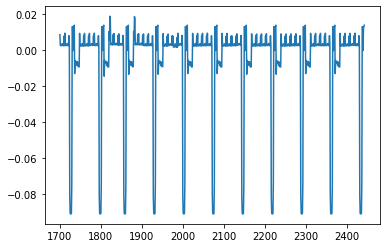

In [47]:
plt.figure()
plt.plot(curr.RF_results)
#plt.plot(curr.Residuals_pct_occupied_sarima)
plt.show()

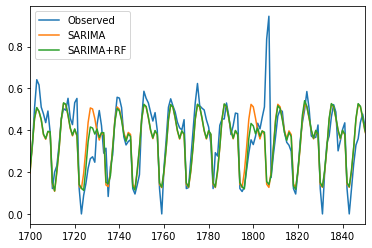

In [48]:
fig, ax = plt.subplots()
ax.plot(curr['PercentOccupied'], label='Observed')

ax.plot(curr['SARIMA_Preds'], label='SARIMA')
ax.plot(curr['SARIMA_Plus_RF'], label='SARIMA+RF')
ax.legend()
ax.set_xlim(1700,1850)
plt.show()

In [49]:
arima3_results = pd.read_pickle('arima_results3/arima_results.pkl')
arima3_results.head()

,ArimaSmapeErrors,GBMSmapeErrors,TrainingSetLength,ArimaRMSEs,ModelOrder,TestVals,ArimaPreds,GBMPreds,NonSeasonal,Seasonal,p,d,q,P,D,Q,m,ArimaSmapeErrors_org
SourceElementKey,,,,,,,,,,,,,,,,,,
1001,16.627545,20.289312,1710,0.114824,"((0, 0, 0), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 18:00:00 0.121...,"[0.14342548005930653, 0.10816144442303331, 0.1...","[0.3234989236773411, 0.3234989236773411, 0.323...","(0, 0, 0)","(4, 0, 4, 12)",0,0,0,4,0,4,12,30.826775
1002,15.389877,20.315699,1710,0.105749,"((1, 0, 1), (4, 0, 4, 12))",OccupancyDateTime 2019-06-20 18:00:00 0.121...,"[0.11628836533130664, 0.09052023912813748, 0.1...","[0.3084913086619947, 0.3084913086619947, 0.308...","(1, 0, 1)","(4, 0, 4, 12)",1,0,1,4,0,4,12,30.916092
1006,10.864261,15.851796,1713,0.077679,"((1, 0, 3), (4, 0, 3, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.264...,"[0.22858474416047397, 0.20060697808277217, 0.1...","[0.2739473230825814, 0.2739473230825814, 0.273...","(1, 0, 3)","(4, 0, 3, 12)",1,0,3,4,0,3,12,23.858915
1009,9.721457,16.294263,1713,0.092156,"((2, 0, 2), (2, 0, 2, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.425...,"[0.49878056740916354, 0.5439141832878749, 0.42...","[0.39008973556375254, 0.39008973556375254, 0.3...","(2, 0, 2)","(2, 0, 2, 12)",2,0,2,2,0,2,12,35.346899
1010,8.769851,15.738368,1713,0.074922,"((1, 0, 0), (5, 0, 2, 12))",OccupancyDateTime 2019-06-20 17:00:00 0.386...,"[0.4675529010924123, 0.5045618431812267, 0.397...","[0.3773656404765852, 0.3773656404765852, 0.377...","(1, 0, 0)","(5, 0, 2, 12)",1,0,0,5,0,2,12,19.594693


In [50]:
arima3_results['ArimaPlusRFSmapeErrors'] = np.nan
for block in arima3_results.index.values:
    mask = (merged['SourceElementKey'] == block) & (merged['OccupancyDateTime'] > (test_date))
    curr = merged[mask]
    if len(curr.SARIMA_Plus_RF) > 0:
    
        arima_rf_smape = smape_error(curr.SARIMA_Plus_RF, curr.PercentOccupied)
        arima3_results.at[block, 'ArimaPlusRFSmapeErrors'] = arima_rf_smape
    else:
        print(block)

In [51]:
arima3_results[['ArimaPlusRFSmapeErrors', 'ArimaSmapeErrors', 'GBMSmapeErrors']].dropna(axis=0).mean()

ArimaPlusRFSmapeErrors    10.177651
ArimaSmapeErrors          10.452048
GBMSmapeErrors            15.465288
dtype: float64

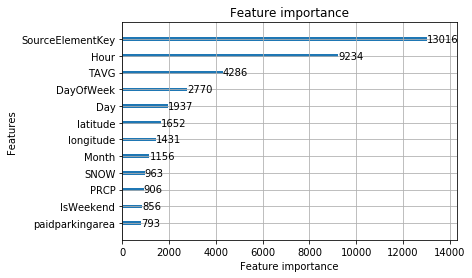

In [52]:
lgb.plot_importance(gbm_rf)

In [53]:
lgb.create_tree_digraph(gbm_rf)

ImportError: You must install graphviz to plot tree.